# torch-sla Visualization Examples

This notebook demonstrates the `spy()` method for visualizing sparse matrix patterns with grayscale intensity.


In [1]:
import sys
sys.path.insert(0, '..')

import torch
import matplotlib.pyplot as plt
from torch_sla import SparseTensor, SparseTensorList

%matplotlib inline
plt.rcParams['figure.dpi'] = 100


/minimax-dialogue/users/walker/.config/matplotlib is not a writable directory


Matplotlib created a temporary cache directory at /tmp/matplotlib-gm2g8oxz because there was an issue with the default path (/minimax-dialogue/users/walker/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


/minimax-dialogue/users/walker/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Create a 2D Poisson Matrix

The 2D Poisson equation with 5-point stencil creates a sparse matrix with a characteristic banded structure.


In [2]:
def create_poisson_2d(n: int, dtype=torch.float64):
    """Create 2D Poisson matrix with 5-point stencil."""
    N = n * n
    idx = torch.arange(N)
    i, j = idx // n, idx % n
    
    entries = [
        (idx, idx, torch.full((N,), 4.0, dtype=dtype)),
        (idx[j > 0], idx[j > 0] - 1, torch.full(((j > 0).sum(),), -1.0, dtype=dtype)),
        (idx[j < n-1], idx[j < n-1] + 1, torch.full(((j < n-1).sum(),), -1.0, dtype=dtype)),
        (idx[i > 0], idx[i > 0] - n, torch.full(((i > 0).sum(),), -1.0, dtype=dtype)),
        (idx[i < n-1], idx[i < n-1] + n, torch.full(((i < n-1).sum(),), -1.0, dtype=dtype)),
    ]
    
    row = torch.cat([e[0] for e in entries])
    col = torch.cat([e[1] for e in entries])
    val = torch.cat([e[2] for e in entries])
    
    return SparseTensor(val, row, col, (N, N))

# Create a small Poisson matrix
A = create_poisson_2d(10)
print(f"Matrix: {A}")
print(f"Sparsity: {1 - A.nnz / (100 * 100):.1%}")


Matrix: SparseTensor(shape=(100, 100), sparse=(100, 100), nnz=460, dtype=torch.float64, device=cpu)
Sparsity: 95.4%


## 2. Basic spy() Plot

The `spy()` method visualizes the sparsity pattern with value intensity shown in grayscale.


<Axes: title={'center': 'Sparse Matrix: 100×100, nnz=460, sparsity=95.4%'}, xlabel='Column', ylabel='Row'>

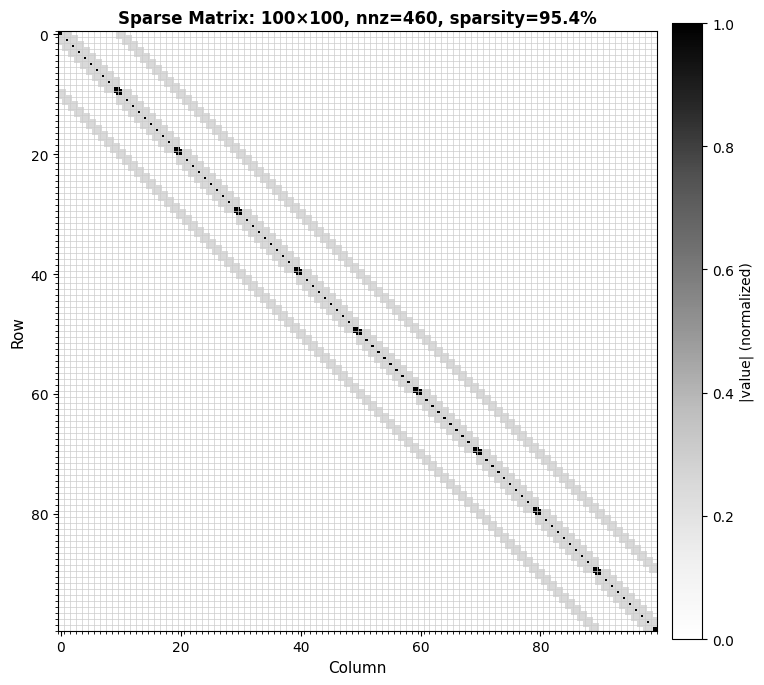

In [3]:
# Basic spy plot with grid
A.spy(figsize=(8, 8))


## 3. Different Colormaps

You can use various colormaps to highlight different aspects of the matrix.


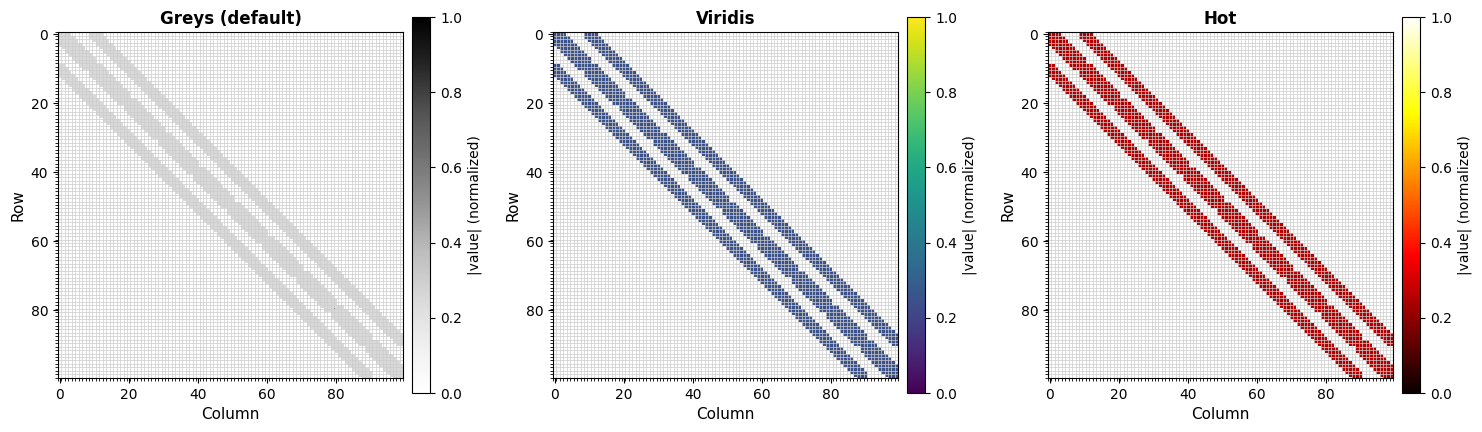

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Different colormaps
A.spy(ax=axes[0], cmap='Greys', title='Greys (default)')
A.spy(ax=axes[1], cmap='viridis', title='Viridis')
A.spy(ax=axes[2], cmap='hot', title='Hot')

plt.tight_layout()


## 4. Grid Options


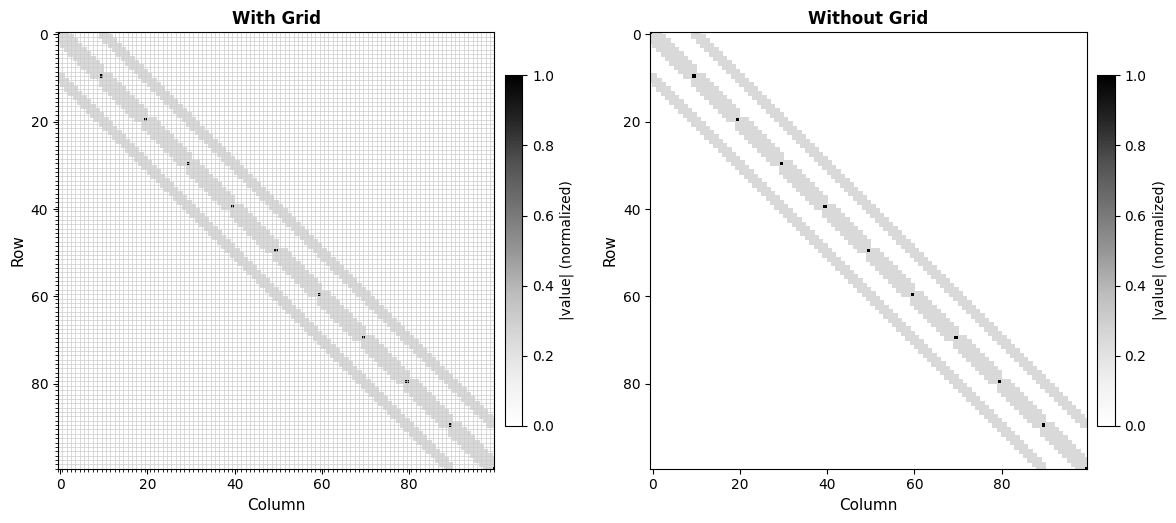

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

A.spy(ax=axes[0], show_grid=True, title='With Grid')
A.spy(ax=axes[1], show_grid=False, title='Without Grid')

plt.tight_layout()


## 5. Larger Matrix

For larger matrices, the visualization automatically adjusts marker size.


Large matrix: SparseTensor(shape=(2500, 2500), sparse=(2500, 2500), nnz=12300, dtype=torch.float64, device=cpu)


<Axes: title={'center': 'Sparse Matrix: 2500×2500, nnz=12,300, sparsity=99.8%'}, xlabel='Column', ylabel='Row'>

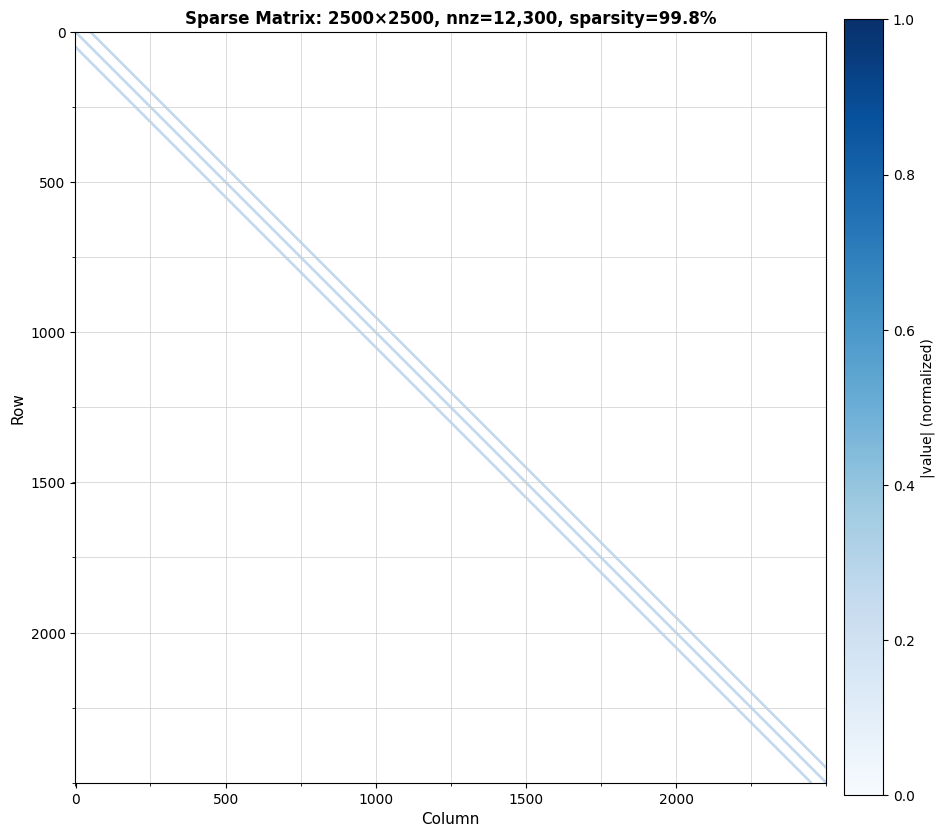

In [6]:
# Larger 50x50 grid = 2500x2500 matrix
A_large = create_poisson_2d(50)
print(f"Large matrix: {A_large}")

A_large.spy(figsize=(10, 10), cmap='Blues')


## 6. Structured vs Random

Compare structured sparsity patterns with random ones.


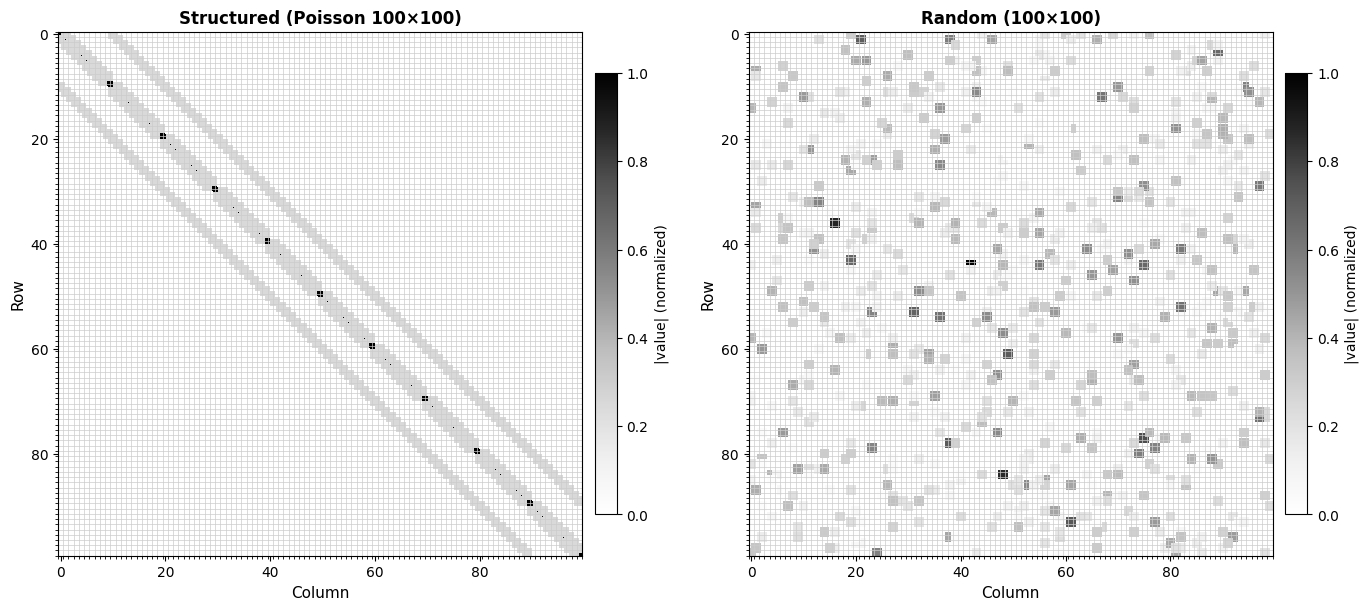

In [7]:
# Create random sparse matrix
n = 100
nnz = 800
row = torch.randint(0, n, (nnz,))
col = torch.randint(0, n, (nnz,))
val = torch.randn(nnz, dtype=torch.float64)

B = SparseTensor(val, row, col, (n, n))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

A.spy(ax=axes[0], cmap='Greys', title='Structured (Poisson 100×100)')
B.spy(ax=axes[1], cmap='Greys', title='Random (100×100)')

plt.tight_layout()


## 7. Tridiagonal Matrix

Classic tridiagonal structure from 1D problems.


Tridiagonal: SparseTensor(shape=(50, 50), sparse=(50, 50), nnz=148, dtype=torch.float64, device=cpu)


<Axes: title={'center': 'Tridiagonal Matrix (Red=positive, Blue=negative)'}, xlabel='Column', ylabel='Row'>

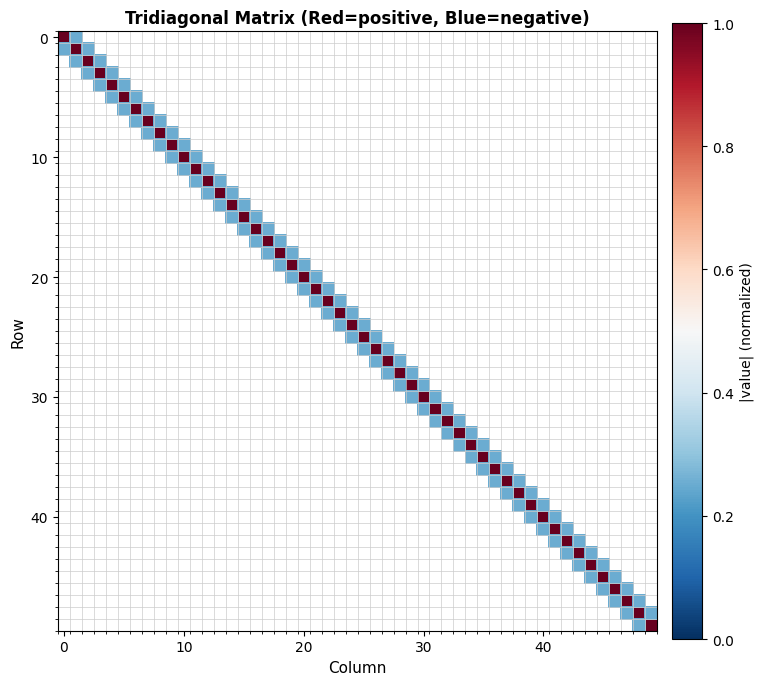

In [8]:
def create_tridiagonal(n: int, dtype=torch.float64):
    """Create tridiagonal SPD matrix."""
    idx = torch.arange(n)
    
    # Diagonal
    diag_row, diag_col = idx, idx
    diag_val = torch.full((n,), 4.0, dtype=dtype)
    
    # Sub-diagonal
    sub_row, sub_col = idx[1:], idx[:-1]
    sub_val = torch.full((n - 1,), -1.0, dtype=dtype)
    
    # Super-diagonal
    sup_row, sup_col = idx[:-1], idx[1:]
    sup_val = torch.full((n - 1,), -1.0, dtype=dtype)
    
    row = torch.cat([diag_row, sub_row, sup_row])
    col = torch.cat([diag_col, sub_col, sup_col])
    val = torch.cat([diag_val, sub_val, sup_val])
    
    return SparseTensor(val, row, col, (n, n))

T = create_tridiagonal(50)
print(f"Tridiagonal: {T}")

T.spy(figsize=(8, 8), cmap='RdBu_r', show_colorbar=True, title='Tridiagonal Matrix (Red=positive, Blue=negative)')


## 8. Block Diagonal Matrix


Block diagonal: SparseTensor(shape=(50, 50), sparse=(50, 50), nnz=500, dtype=torch.float64, device=cpu)


<Axes: title={'center': 'Block Diagonal (5 blocks of 10×10)'}, xlabel='Column', ylabel='Row'>

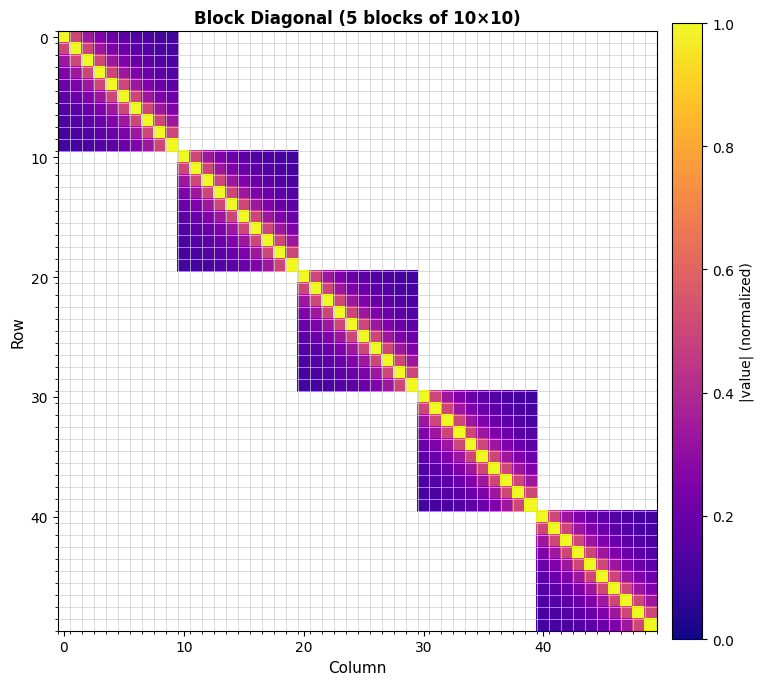

In [9]:
def create_block_diagonal(block_size: int, num_blocks: int, dtype=torch.float64):
    """Create block diagonal matrix with dense blocks."""
    n = block_size * num_blocks
    
    # Create indices for all blocks
    blocks = []
    for b in range(num_blocks):
        offset = b * block_size
        # Create a full block
        block_i = torch.arange(block_size).repeat_interleave(block_size) + offset
        block_j = torch.arange(block_size).repeat(block_size) + offset
        # Value decays from diagonal
        i_local = torch.arange(block_size).repeat_interleave(block_size)
        j_local = torch.arange(block_size).repeat(block_size)
        block_v = 1.0 / (1 + torch.abs(i_local - j_local).float())
        blocks.append((block_i, block_j, block_v.to(dtype)))
    
    row = torch.cat([b[0] for b in blocks])
    col = torch.cat([b[1] for b in blocks])
    val = torch.cat([b[2] for b in blocks])
    
    return SparseTensor(val, row, col, (n, n))

BD = create_block_diagonal(10, 5)
print(f"Block diagonal: {BD}")

BD.spy(figsize=(8, 8), cmap='plasma', title='Block Diagonal (5 blocks of 10×10)')


## 9. SparseTensorList Visualization

Visualize multiple matrices in a grid layout.


SparseTensorList: SparseTensorList(n=4, device=cpu)
Shapes: [(30, 30), (25, 25), (20, 20), (30, 30)]


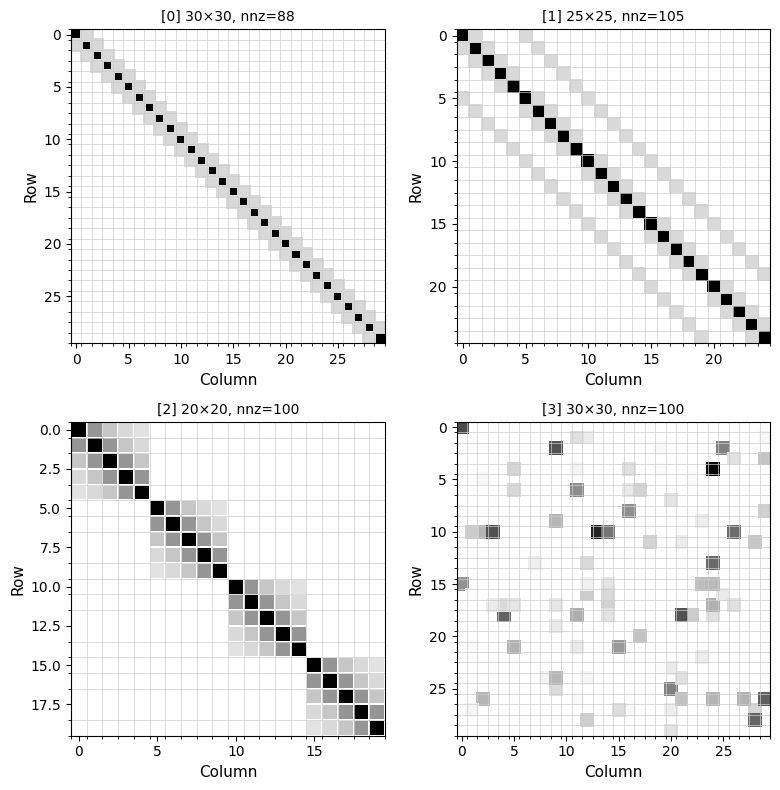

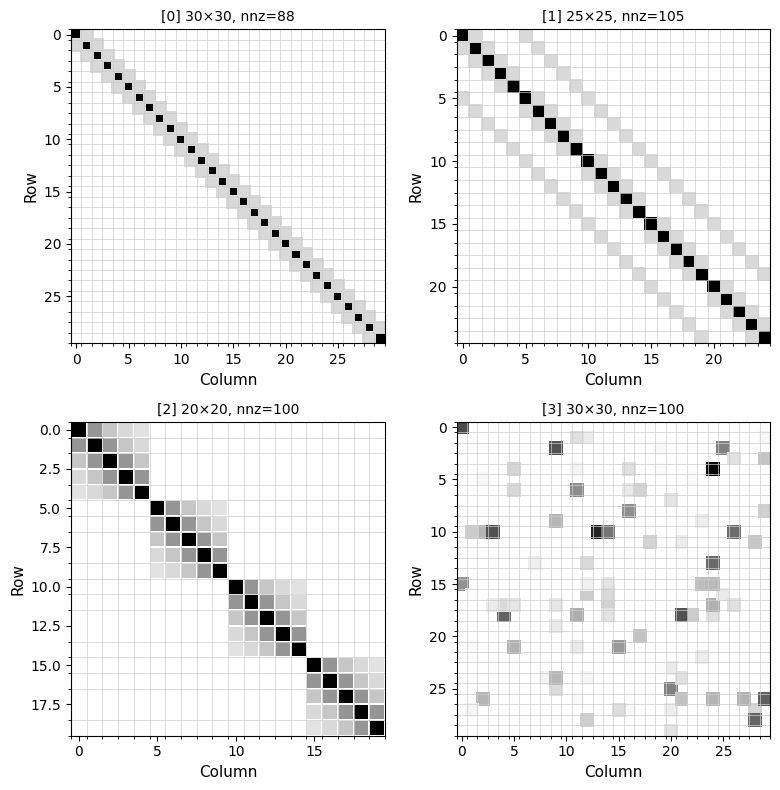

In [10]:
# Create list of matrices with different structures
matrices = SparseTensorList([
    create_tridiagonal(30),
    create_poisson_2d(5),  # 25x25
    create_block_diagonal(5, 4),  # 20x20
    SparseTensor(
        torch.randn(100, dtype=torch.float64),
        torch.randint(0, 30, (100,)),
        torch.randint(0, 30, (100,)),
        (30, 30)
    ),
])

print(f"SparseTensorList: {matrices}")
print(f"Shapes: {matrices.shapes}")

# Visualize all in grid
matrices.spy(ncols=2, cmap='Greys', title='Different Sparsity Patterns')


## 10. Saving Figures

Use `save_path` to export visualizations.


Saved to poisson_spy.png


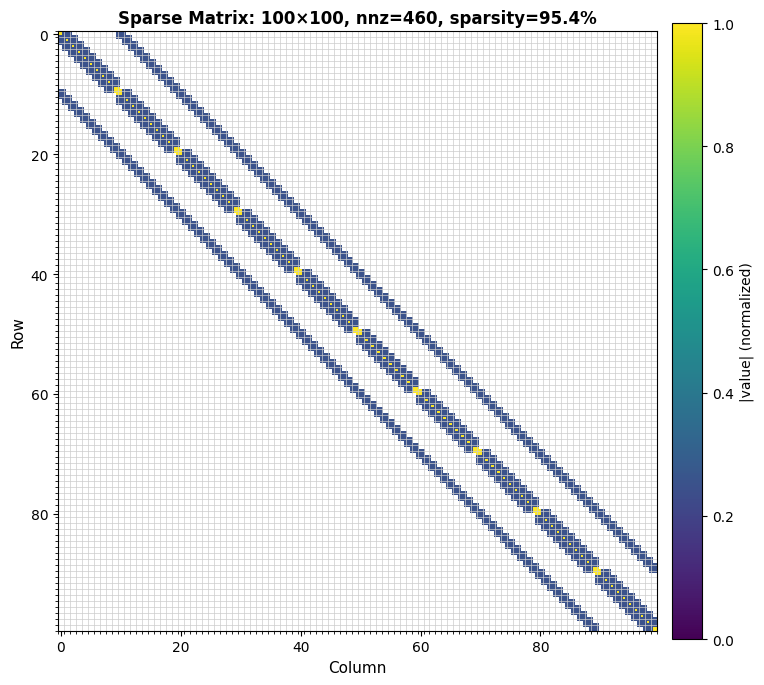

In [11]:
# Save to file
A.spy(
    cmap='viridis',
    show_colorbar=True,
    save_path='poisson_spy.png',
    dpi=150
)
print("Saved to poisson_spy.png")


## 11. Graph Adjacency Matrix

Visualize a graph's adjacency matrix (ring graph + random edges).


Graph adjacency: SparseTensor(shape=(50, 50), sparse=(50, 50), nnz=310, dtype=torch.float64, device=cpu)


<Axes: title={'center': 'Graph Adjacency (50 nodes)'}, xlabel='Column', ylabel='Row'>

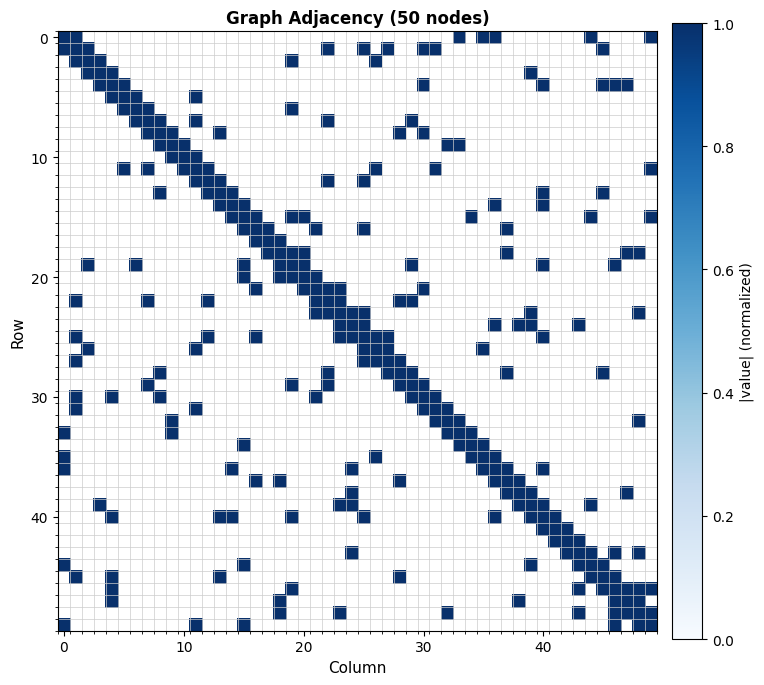

In [12]:
# Create a ring graph with random edges
n_nodes = 50

# Ring edges
ring_src = torch.arange(n_nodes)
ring_dst = (ring_src + 1) % n_nodes

# Random additional edges
n_random = 80
rand_src = torch.randint(0, n_nodes, (n_random,))
rand_dst = torch.randint(0, n_nodes, (n_random,))

# Combine (undirected = symmetric)
row = torch.cat([ring_src, ring_dst, rand_src, rand_dst])
col = torch.cat([ring_dst, ring_src, rand_dst, rand_src])

# Add self-loops
self_loops = torch.arange(n_nodes)
row = torch.cat([row, self_loops])
col = torch.cat([col, self_loops])
val = torch.ones(len(row), dtype=torch.float64)

G = SparseTensor(val, row, col, (n_nodes, n_nodes))
print(f"Graph adjacency: {G}")

G.spy(figsize=(8, 8), cmap='Blues', title=f'Graph Adjacency ({n_nodes} nodes)')


 哦运行ipynb